In [1]:
from IPython.display import display
import os

# 上傳檔案（會跳出檔案選擇器）
from ipywidgets import FileUpload

upload = FileUpload()
display(upload)

FileUpload(value=(), description='Upload')

In [2]:
import os
from pathlib import Path

# 假設你只上傳了一個檔案
fileinfo = upload.value[0]  # 通常是一個 dict，含 'name' 和 'content'

# 顯示內容結構（除錯用）
print(fileinfo)

# 儲存 kaggle.json
filename = fileinfo['name']
content = fileinfo['content']

kaggle_dir = Path.home() / ".kaggle"
kaggle_dir.mkdir(exist_ok=True)

kaggle_json_path = kaggle_dir / "kaggle.json"
with open(kaggle_json_path, "wb") as f:
    f.write(content)

# 設定權限（Linux/macOS 建議）
os.chmod(kaggle_json_path, 0o600)

print(f"{filename} 已成功儲存至 {kaggle_json_path}")

{'name': 'kaggle (1).json', 'type': 'application/json', 'size': 69, 'content': <memory at 0x7fbdf3d67d00>, 'last_modified': datetime.datetime(2025, 5, 21, 13, 44, 12, 496000, tzinfo=datetime.timezone.utc)}
kaggle (1).json 已成功儲存至 /home/jovyan/.kaggle/kaggle.json


In [3]:
import os
import zipfile

import pandas as pd

labels = pd.read_csv('dog-breed-identification/labels.csv')

import numpy as np


In [4]:
import os
import shutil
import pandas as pd
from PIL import Image
from tqdm import tqdm
# 讀取標籤
labels = pd.read_csv('dog-breed-identification/labels.csv')
# 建立目標輸出資料夾
output_dir = "dog_images"
train_dir = os.path.join(output_dir, "train")
os.makedirs(train_dir, exist_ok=True)

# 根據標籤將圖片存入對應資料夾
def organize_train_images(labels): # Pass labels as an argument
    src_img_dir = "dog-breed-identification/train"
    for idx, row in tqdm(labels.iterrows(), total=len(labels)):
        img_id = row['id']
        breed = row['breed']
        src_path = os.path.join(src_img_dir, img_id + ".jpg")

        # 建立品種對應資料夾
        breed_dir = os.path.join(train_dir, breed)
        os.makedirs(breed_dir, exist_ok=True)

        dst_path = os.path.join(breed_dir, img_id + ".jpg")
        shutil.copyfile(src_path, dst_path)

# Load labels outside the function
labels = pd.read_csv('dog-breed-identification/labels.csv')
organize_train_images(labels) # Call the function with labels argument

100%|██████████| 10222/10222 [00:47<00:00, 216.88it/s]


In [5]:
 #自定義 Dataset 類別
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

class DogBreedImageFolder(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # 建立類別對應表：品種 → 數值 label
        class_names = sorted(os.listdir(root_dir))
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

        for class_name in class_names:
            class_folder = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_folder):
                continue
            for filename in os.listdir(class_folder):
                if filename.endswith(('.jpg', '.png')):
                    self.image_paths.append(os.path.join(class_folder, filename))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [6]:
# 定義 Transform
from torchvision.transforms import RandomResizedCrop, RandomHorizontalFlip, ColorJitter, RandomRotation, ToTensor, Normalize

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),  # 使用 ImageNet 的 mean/std
                         (0.229, 0.224, 0.225)),
])


test_transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [9]:
# 建立 Dataset 與切分
from torch.utils.data import random_split, DataLoader, WeightedRandomSampler
import collections
from collections import Counter

# 讀取分類後資料
dataset = DogBreedImageFolder("dog_images/train", transform=train_transform)

# 計算資料數量與切分比例
val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 取得 training set 的原始 indices
train_indices = train_dataset.indices  # 是 dataset 中對應的索引
train_labels = [dataset.labels[i] for i in train_indices]

# 計算類別樣本數與每個 sample 權重
label_counts = Counter(train_labels)
class_sample_counts = [label_counts[i] for i in range(len(label_counts))]
sample_weights = [1.0 / class_sample_counts[label] for label in train_labels]

# 建立 WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# 建立 DataLoader（train 用 sampler, val 用 shuffle=False）
train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# 顯示類別分布（驗證分布仍可看是否合理）
val_labels = [dataset.labels[i] for i in val_dataset.indices]
print("Train label distribution:", Counter(train_labels))
print("Val label distribution:", Counter(val_labels))
#這是調平衡的

Train label distribution: Counter({1: 94, 7: 94, 9: 92, 87: 92, 52: 92, 97: 92, 94: 91, 109: 91, 11: 91, 100: 90, 42: 89, 69: 88, 26: 87, 73: 86, 75: 85, 3: 85, 88: 83, 59: 82, 13: 82, 6: 81, 30: 80, 61: 80, 93: 80, 17: 79, 68: 79, 60: 77, 117: 76, 56: 75, 70: 73, 84: 73, 54: 73, 101: 73, 15: 72, 35: 71, 78: 71, 79: 70, 98: 70, 64: 70, 14: 70, 90: 70, 12: 70, 86: 70, 102: 70, 10: 70, 55: 69, 19: 69, 82: 69, 80: 69, 57: 69, 2: 68, 8: 67, 33: 67, 58: 67, 119: 67, 92: 67, 40: 67, 116: 66, 20: 66, 50: 66, 62: 66, 76: 66, 96: 65, 74: 65, 95: 65, 53: 65, 107: 64, 104: 64, 63: 64, 36: 64, 110: 64, 39: 64, 118: 64, 67: 64, 114: 64, 28: 63, 37: 63, 115: 63, 111: 63, 105: 63, 71: 62, 5: 62, 27: 62, 113: 62, 65: 62, 25: 61, 85: 61, 4: 61, 51: 61, 103: 60, 0: 60, 38: 60, 41: 60, 81: 60, 77: 60, 99: 60, 66: 59, 108: 58, 29: 58, 18: 58, 44: 58, 31: 58, 24: 57, 16: 57, 83: 57, 43: 56, 22: 56, 34: 56, 106: 56, 49: 56, 23: 56, 32: 55, 91: 55, 72: 54, 89: 54, 112: 54, 47: 53, 21: 52, 48: 51, 45: 48, 46:

In [10]:
from torchvision import transforms
from PIL import Image

def collate_with_resize(batch, image_size):
    images, labels = zip(*batch)
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),  # 直接縮放 tensor
    ])
    images = [transform(img) if isinstance(img, torch.Tensor) else transform(transforms.ToTensor()(img)) for img in images]
    return torch.stack(images), torch.tensor(labels)


In [11]:
# ✅ 動態圖像大小
image_size = 320  # or 320
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,
                          collate_fn=lambda batch: collate_with_resize(batch, image_size))

# 測試一個 batch
for images, labels in train_loader:
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    break


Images shape: torch.Size([16, 3, 320, 320])
Labels shape: torch.Size([16])


In [12]:
#驗證資料載入
# 驗證一個 batch
for images, labels in train_loader:
    print("Images shape:", images.shape)  # [B, 3, 224, 224]
    print("Labels shape:", labels.shape)  # [B]
    break

Images shape: torch.Size([16, 3, 320, 320])
Labels shape: torch.Size([16])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


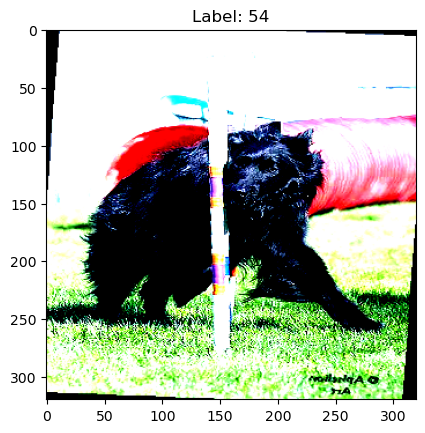

In [13]:
# 如果需要視覺化一個 batch
import matplotlib.pyplot as plt
def show_batch(loader):
    images, labels = next(iter(loader))
    img = images[0].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(f"Label: {labels[0]}")
    plt.show()

show_batch(train_loader)

In [15]:
!pip install timm

  Using cached timm-1.0.15-py3-none-any.whl (2.4 MB)
  Using cached safetensors-0.5.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (471 kB)


In [16]:
import torch
import torch.nn as nn
import timm

class TwoModelFusion(nn.Module):
    def __init__(self, num_classes=120, pretrained=True):
        super().__init__()
        # Model 1: Xception
        self.model1 = timm.create_model('xception', pretrained=pretrained, num_classes=0)
        self.feature_dim1 = self.model1.num_features
        
        # Model 2: ResNet50
        self.model2 = timm.create_model('resnet50', pretrained=pretrained, num_classes=0)
        self.feature_dim2 = self.model2.num_features
        
        # Combined feature dimension
        fused_dim = self.feature_dim1 + self.feature_dim2
        
        # Classifier head
        self.classifier = nn.Sequential(
            nn.Linear(fused_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        feat1 = self.model1(x)
        feat2 = self.model2(x)

        # Flatten if needed
        if len(feat1.shape) > 2:
            feat1 = torch.flatten(feat1, start_dim=1)
        if len(feat2.shape) > 2:
            feat2 = torch.flatten(feat2, start_dim=1)

        fused = torch.cat([feat1, feat2], dim=1)
        out = self.classifier(fused)
        return out

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model
model = TwoModelFusion(num_classes=120).to(device)

# Freeze backbone (optional)
for param in model.model1.parameters():
    param.requires_grad = False
for param in model.model2.parameters():
    param.requires_grad = False

# Ensure classifier is trainable
for param in model.classifier.parameters():
    param.requires_grad = True


/opt/conda/lib/python3.9/site-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /home/jovyan/.cache/torch/hub/checkpoints/xception-43020ad28.pth


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [17]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing

    def forward(self, logits, target):
        log_probs = nn.functional.log_softmax(logits, dim=-1)
        nll_loss = -log_probs.gather(dim=-1, index=target.unsqueeze(1)).squeeze(1)
        smooth_loss = -log_probs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()


In [18]:
from torch.optim.lr_scheduler import _LRScheduler

class GradualWarmupScheduler(_LRScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None, last_epoch=-1):
        self.multiplier = multiplier
        if self.multiplier <= 1.:
            raise ValueError('multiplier should be greater than 1.')
        self.total_epoch = total_epoch
        self.after_scheduler = after_scheduler
        self.finished = False
        super(GradualWarmupScheduler, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch >= self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]

        return [
            base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.)
            for base_lr in self.base_lrs
        ]

    def step(self, epoch=None):
        if self.finished and self.after_scheduler:
            if epoch is None:
                self.after_scheduler.step(None)
            else:
                self.after_scheduler.step(epoch - self.total_epoch)
        else:
            return super(GradualWarmupScheduler, self).step(epoch)


In [19]:
from collections import Counter
from torchvision import transforms
from torch.optim.lr_scheduler import CosineAnnealingLR

num_epochs = 50
warmup_epochs = 5
# 計算各類別的樣本數
label_counts = Counter(dataset.labels)
num_classes = len(label_counts)
class_counts = [label_counts[i] for i in range(num_classes)]

# 計算每個類別的權重：樣本數越少，權重越高
weights = [1.0 / c for c in class_counts]
weights = torch.tensor(weights, dtype=torch.float).to(device)

# 使用 class weights + label smoothing
criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

cosine_scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs - warmup_epochs)
scheduler = GradualWarmupScheduler(
    optimizer,
    multiplier=5.0,               # 最終學習率 = 初始 * 1.0
    total_epoch=warmup_epochs,
    after_scheduler=cosine_scheduler
)


In [20]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

def get_dataloaders(image_size, batch_size):
    transform_train = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])
    transform_val = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ])

    train_dataset = ImageFolder(train_dir, transform=transform_train)
    val_dataset = ImageFolder(val_dir, transform=transform_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader


In [21]:
class EarlyStopping:
    def __init__(self, patience=8, verbose=False, delta=0, path='best_model.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''儲存目前最佳模型'''
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} → {val_loss:.6f}). Saving model...")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [22]:
small_image_epochs = 5
small_size = 224
large_size = 320
batch_size = 64

early_stopping = EarlyStopping(patience=8, verbose=True, path='best_resnet50.pth')

full_dataset = DogBreedImageFolder("dog_images/train", transform=train_transform)

for epoch in range(num_epochs):
    image_size = small_size if epoch < small_image_epochs else large_size

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              collate_fn=lambda batch: collate_with_resize(batch, image_size))
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                            collate_fn=lambda batch: collate_with_resize(batch, image_size))

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    scheduler.step()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Size: {image_size}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# 載入最佳模型
model.load_state_dict(torch.load("best_resnet50.pth"))


Epoch 1/50, Size: 224, Loss: 4.1991, Accuracy: 19.10%
Validation Loss: 2.8577, Validation Accuracy: 53.42%
Validation loss decreased (inf → 2.857654). Saving model...
Epoch 2/50, Size: 224, Loss: 2.3872, Accuracy: 54.87%
Validation Loss: 1.8176, Validation Accuracy: 72.55%
Validation loss decreased (2.857654 → 1.817619). Saving model...
Epoch 3/50, Size: 224, Loss: 1.9173, Accuracy: 68.01%
Validation Loss: 1.7124, Validation Accuracy: 75.05%
Validation loss decreased (1.817619 → 1.712416). Saving model...
Epoch 4/50, Size: 224, Loss: 1.7633, Accuracy: 73.06%
Validation Loss: 1.6499, Validation Accuracy: 77.20%
Validation loss decreased (1.712416 → 1.649945). Saving model...


/opt/conda/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:807: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 5/50, Size: 224, Loss: 1.6780, Accuracy: 76.02%
Validation Loss: 1.6424, Validation Accuracy: 76.22%
Validation loss decreased (1.649945 → 1.642353). Saving model...
Epoch 6/50, Size: 320, Loss: 1.3853, Accuracy: 86.00%
Validation Loss: 1.3026, Validation Accuracy: 87.28%
Validation loss decreased (1.642353 → 1.302630). Saving model...
Epoch 7/50, Size: 320, Loss: 1.3023, Accuracy: 88.68%
Validation Loss: 1.2686, Validation Accuracy: 88.11%
Validation loss decreased (1.302630 → 1.268605). Saving model...
Epoch 8/50, Size: 320, Loss: 1.2681, Accuracy: 90.07%
Validation Loss: 1.2733, Validation Accuracy: 87.33%
EarlyStopping counter: 1 out of 8
Epoch 9/50, Size: 320, Loss: 1.2319, Accuracy: 91.13%
Validation Loss: 1.2942, Validation Accuracy: 87.18%
EarlyStopping counter: 2 out of 8
Epoch 10/50, Size: 320, Loss: 1.2022, Accuracy: 92.15%
Validation Loss: 1.2737, Validation Accuracy: 87.38%
EarlyStopping counter: 3 out of 8
Epoch 11/50, Size: 320, Loss: 1.1800, Accuracy: 93.07%
Valid

<All keys matched successfully>

In [23]:
# 保存訓練後的模型
torch.save(model.state_dict(), "dog_breed_model.pth")


In [24]:
# 測試集的評估
test_accuracy = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        test_accuracy += (predicted == labels).sum().item()

test_accuracy = 100 * test_accuracy / len(val_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}%")

import os

Test Accuracy: 88.80%


In [25]:
# 測試集的評估
tta_transforms = [
    transforms.Compose([transforms.Resize((320, 320)), transforms.ToTensor()]),
    transforms.Compose([transforms.Resize((320, 320)), transforms.RandomHorizontalFlip(p=1.0), transforms.ToTensor()]),
    transforms.Compose([transforms.Resize((320, 320)), transforms.ColorJitter(brightness=0.2), transforms.ToTensor()])
]

model.eval()
total = 0
correct = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        tta_preds = []
        for tform in tta_transforms:
            aug_images = torch.stack([tform(transforms.ToPILImage()(img.cpu())) for img in images])
            aug_images = aug_images.to(device)
            outputs = model(aug_images)
            tta_preds.append(torch.softmax(outputs, dim=1))

        avg_preds = torch.mean(torch.stack(tta_preds), dim=0)
        _, predicted = torch.max(avg_preds, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"TTA Test Accuracy: {accuracy:.2f}%")


TTA Test Accuracy: 1.66%


In [26]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class TestImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_filenames = sorted(os.listdir(image_folder))
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_name.split('.')[0]  # 傳回 image tensor 和 id（

In [27]:
# 取得所有類別名稱，需排序以符合 submission 格式
all_breeds = sorted(dataset.class_to_idx.keys())

# 建立 mapping
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
# 修正 Test transform 使用與訓練相同的 ImageNet 格式
test_transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),  # 與訓練相同
                         (0.229, 0.224, 0.225))
])


# 設定測試資料夾路徑
test_folder = 'dog-breed-identification/test'  # 請確認實際位置

# 建立 DataLoader
test_dataset = TestImageDataset(test_folder, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 建立 DataFrame 儲存預測結果
results = []

In [28]:
# 使用 softmax 輸出機率
results = []

with torch.no_grad():
    for inputs, image_ids in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()  # shape: (batch_size, 120)

        for img_id, prob_vector in zip(image_ids, probs):
            row = {"id": img_id}
            for breed, prob in zip(all_breeds, prob_vector):
                row[breed] = prob
            results.append(row)

# 轉成 DataFrame 並輸出
df = pd.DataFrame(results)
df = df[["id"] + all_breeds]  # 確保順序符合要求
df.to_csv("submission_Mix.csv", index=False)
print("✅ submission_Mix.csv 已成功輸出，格式符合 Kaggle 要求！")

✅ submission_Mix.csv 已成功輸出，格式符合 Kaggle 要求！
